In [13]:
%pylab inline
import torch
import numpy
import sklearn.datasets
import torchvision.datasets
import os
from scipy.misc import imresize as imgresize
from pycocotools import coco

torch.manual_seed(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Populating the interactive namespace from numpy and matplotlib


/home/teacher/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['stack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
train_dest = "../../val2017"
target_dest = "../../annotations/instances_val2017_categories.json"

In [15]:
# import json 

# with open("../../annotations/instances_val2017.json") as rfile, open("../../annotations/instances_val2017_categories.json", 'w') as wfile:
#     data = json.load(rfile)
    
#     new_categories = list(set(list(x["category_id"] for x in data["annotations"])))
#     def change_category(ann):
#         ann["category_id"] = new_categories.index(ann["category_id"])
#         return ann
    
#     data["annotations"] = list(map(change_category, data["annotations"]))
#     json.dump(data, wfile)
   
# with open("../../annotations/instances_train2017.json") as rfile, open("../../annotations/instances_train2017_categories.json", 'w') as wfile:
#     data = json.load(rfile)
    
#     new_categories = list(set(list(x["category_id"] for x in data["annotations"])))
#     def change_category(ann):
#         ann["category_id"] = new_categories.index(ann["category_id"])
#         return ann
    
#     data["annotations"] = list(map(change_category, data["annotations"]))
#     json.dump(data, wfile)

In [26]:
COCO = coco.COCO(target_dest)
category_ids = 80
people_category = 0
size = (32, 32)
def toResizedTensor(np_image):
    np_image = (imgresize(np_image, size, 'bilinear') > 0).astype(int)
    return torch.from_numpy(np_image).float().unsqueeze(0)

def toMask(x):
    masks = torch.zeros(80, 1, *size)
    for ann in x:
        category = ann["category_id"]
        mask = COCO.annToMask(ann)
        mask = toResizedTensor(mask)
        masks[category] += mask
    return masks

loading annotations into memory...
Done (t=0.87s)
creating index...
index created!


In [27]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size), #реобразует картинку к указанному размеру
         torchvision.transforms.ToTensor()                   # Переводит объект "картинка" к torch.Tensor
    ])

train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Lambda(toMask),      
    ])

In [28]:
dataset = torchvision.datasets.CocoDetection(train_dest, target_dest, 
                                             transform=transforms, target_transform=train_transforms)

data_loader = torch.utils.data.DataLoader(
    dataset,
    shuffle=True,
    pin_memory=True,
    batch_size=1,
    num_workers=4)

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!


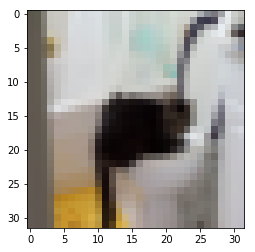

In [29]:
plt.imshow(dataset[3][0].numpy().swapaxes(0,1).swapaxes(1,2))
plt.show()

In [30]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [31]:
class UNetConvBlock(torch.nn.Module):
    def __init__(self, in_layers, out_layers, kernel_size=3, padding=1, activation=torch.nn.ReLU, pooling=True):
        super(UNetConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(in_layers, out_layers, kernel_size, padding=padding)
        self.conv2 = torch.nn.Conv2d(out_layers, out_layers, kernel_size, padding=padding)
        self.pooling = pooling
        self.pool = torch.nn.MaxPool2d(2)
        self.activation = activation()
        
    def forward(self, x):
        out = self.activation(self.conv(x))
        out = self.activation(self.conv2(out))
        if (self.pooling):
            out = self.pool(out)
        return out     
    
class UNetUpConvBlock(torch.nn.Module):
    def __init__(self, in_layers, kernel_size=3, padding=1, activation=torch.nn.ReLU):
        super(UNetUpConvBlock, self).__init__()
        self.upconv = torch.nn.Conv2d(in_layers, 4*in_layers, 1)
        self.transpose = torch.nn.ConvTranspose2d(4*in_layers, in_layers, 2, stride=2)
        self.conv = UNetConvBlock(in_layers, in_layers, pooling=False)  
        
    def forward(self, x):
        out = self.upconv(x)
        out = self.transpose(out)
        out = self.conv(out)
        return out    

def stack(old, new):
    return torch.cat([old, new], dim=1)

In [32]:
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.conv1 = UNetConvBlock(3, 16)
        self.conv2 = UNetConvBlock(16, 32)
        self.conv3 = UNetConvBlock(32, 64)

        self.upconv3 = UNetUpConvBlock(64) 
        self.upconv2 = UNetUpConvBlock(96)  # stack with conv2 64 + 32
        self.upconv1 = UNetUpConvBlock(112) # stack with conv1 96 + 16
        
        self.fullconv = torch.nn.Conv2d(115, 80, 1) # with initial 112 + 3
        self.pred = torch.nn.Sigmoid()
        
    def forward(self, x):
        initial = x.clone()
        
        c1 = self.conv1(x)
        c2 = self.conv2(c1)          
        x = self.conv3(c2)
        
        x = self.upconv3(x)
        
        x = stack(c2, x)
        x = self.upconv2(x)
        
        x = stack(c1, x)
        x = self.upconv1(x)
        
        x = stack(initial, x)
        x = self.fullconv(x)  
        x = self.pred(x)
        return x

In [33]:
net = UNet().to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters())

# if os.path.exists("state_dict.wght"):
#     net.load_state_dict(torch.load("state_dict.wght"))

def intersection_over_union(pred, target):
    i, u = 0, 0
    for pred_l, target_l in zip(pred, target):
        i += (pred_l * target_l > 0).sum().item()
        u += (pred_l + target_l > 0).sum().item()
    return i / u

metric = intersection_over_union

In [34]:
for epoch in range(10):
    print("Epoch {} started".format(epoch))
    order = random.permutation(len(dataset.ids))
    net.train()
    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        
        batch_features = data.to(device)
        batch_labels = target.to(device)
        
        batch_preds = net.forward(batch_features)

        loss = criterion(batch_preds, batch_labels)
        loss.backward()
        optimizer.step()
        
        if i % 50 == 0:
            print("Batch {} loss {}, ".format(i, loss.item()), end="")
            print("intersection over union: {}".format(metric(batch_preds, batch_labels)))

Epoch 0 started


RuntimeError: cuda runtime error (2) : out of memory at /pytorch/aten/src/THC/THCTensorCopy.cu:204

In [ ]:
def showimgs(data_loader, net, batches=1):
    for i, (data, target) in enumerate(data_loader):
        pred = net.forward(data.to(device))
        for img_data, border_data, pred_data in zip(data, target, pred):
            fig, (img, border, prediction) = plt.subplots(1, 3)
            img.imshow(img_data.numpy().swapaxes(0,1).swapaxes(1,2))
            border.imshow(border_data.numpy().squeeze(0))
            prediction.imshow(pred_data.cpu().data.numpy().squeeze(0))
            plt.show()
        if (i == batches):
            break
        
        
def showpred(pred):
    for i in pred:
        plt.imshow(i.numpy().squeeze(0))
        plt.show()

In [ ]:
showimgs(data_loader, net, batches=4)

In [ ]:
# torch.save(net.state_dict(), "state_dict.wght")